<a href="https://colab.research.google.com/github/noa-co-98/biodiffusion/blob/main/train_on_imu_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/imics-lab/biodiffusion.git

Cloning into 'biodiffusion'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 653 (delta 9), reused 9 (delta 3), pack-reused 621 (from 1)
Receiving objects: 100% (653/653), 35.32 MiB | 19.90 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F134145%2F318884%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240816%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240816T140832Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5689850e6f4973eda1922758cb613ca43c14f89ffbbf91519cd9bc200b6a5b4bef04ad4940d3fd214a3d8c13172eb750b7be5a0ca65921b6d10682db1470904b6091ee3187b5c35033fb8984e573da8bfb6ed60e1938b1d7172bb29d6b5d353a6473949ff47a1c5732b1b4fc2530dc9638f6990e460a39d9aef1538593ad635aabd45d1c0b36d36e6fa99006bfd66ee9b19f02dde87c94d77fdbd89bca1fe3a1cfd0c10ccb6a2946be145fc6de034e1ea2c61131ae91af8f176ae4c88371c6f42f927a091b526c237347fcaadfa11c6bcb29b7ae8020fe1c024741788e3a09f917dadfb690ee0766b3e7adcc0f8b63a5558961a749055d0ee76d6a9c44556b9b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3179354658 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def from_path_to_df(in_path):
    """Read experiment txt files."""
    with in_path.open('r') as f:
        cur_df = pd.read_csv(f, sep='\s+', header=None, skiprows=1)
        if len(cur_df.columns)==4:
            cur_df.columns = ['timestamp_ns', 'x', 'y', 'z']
        else:
            old_cols = cur_df.columns.tolist()
            old_cols[0] = 'timestamp_ns'
            if len(cur_df.columns)==8:
                old_cols[1] = 'x'
                old_cols[2] = 'y'
                old_cols[3] = 'z'
            cur_df.columns = old_cols
        cur_df['timestamp_s'] = cur_df['timestamp_ns']/1.0e9
        return cur_df.drop('timestamp_ns', axis=1).sort_values('timestamp_s')

In [4]:
BASE_DIR = Path('..') / 'input' / 'data_publish_v2' / 'data_publish_v2'

In [5]:
all_files_df = pd.DataFrame({'path': list(BASE_DIR.glob('*/*.txt'))})
all_files_df['exp_code'] = all_files_df['path'].map(lambda x: x.parent.stem)
all_files_df['activity'] = all_files_df['exp_code'].map(lambda x: '_'.join(x.split('_')[1:]))
all_files_df['person'] = all_files_df['exp_code'].map(lambda x: x.split('_')[0])
all_files_df['data_src'] = all_files_df['path'].map(lambda x: x.stem)
all_files_df.sample(5)

,path,exp_code,activity,person,data_src
479,../input/data_publish_v2/data_publish_v2/ma_ha...,ma_handheld1,handheld1,ma,magnet
138,../input/data_publish_v2/data_publish_v2/hang_...,hang_bag_side1,bag_side1,hang,linacce
554,../input/data_publish_v2/data_publish_v2/zhich...,zhicheng_handheld1,handheld1,zhicheng,step
352,../input/data_publish_v2/data_publish_v2/huayi...,huayi_handheld2,handheld2,huayi,acce
304,../input/data_publish_v2/data_publish_v2/dan_h...,dan_handheld2,handheld2,dan,gyro


In [6]:
data_df = all_files_df.pivot_table(values='path',
                         columns='data_src',
                         index=['activity', 'person'],
                        aggfunc='first').\
    reset_index().\
    dropna(axis=1) # remove mostly empty columns
data_df.head(5)

data_src,activity,person,acce,gravity,gyro,linacce,magnet,orientation,pose
0,bag1,dan,../input/data_publish_v2/data_publish_v2/dan_b...,../input/data_publish_v2/data_publish_v2/dan_b...,../input/data_publish_v2/data_publish_v2/dan_b...,../input/data_publish_v2/data_publish_v2/dan_b...,../input/data_publish_v2/data_publish_v2/dan_b...,../input/data_publish_v2/data_publish_v2/dan_b...,../input/data_publish_v2/data_publish_v2/dan_b...
1,bag1,hao,../input/data_publish_v2/data_publish_v2/hao_b...,../input/data_publish_v2/data_publish_v2/hao_b...,../input/data_publish_v2/data_publish_v2/hao_b...,../input/data_publish_v2/data_publish_v2/hao_b...,../input/data_publish_v2/data_publish_v2/hao_b...,../input/data_publish_v2/data_publish_v2/hao_b...,../input/data_publish_v2/data_publish_v2/hao_b...
2,bag1,huayi,../input/data_publish_v2/data_publish_v2/huayi...,../input/data_publish_v2/data_publish_v2/huayi...,../input/data_publish_v2/data_publish_v2/huayi...,../input/data_publish_v2/data_publish_v2/huayi...,../input/data_publish_v2/data_publish_v2/huayi...,../input/data_publish_v2/data_publish_v2/huayi...,../input/data_publish_v2/data_publish_v2/huayi...
3,bag1,ruixuan,../input/data_publish_v2/data_publish_v2/ruixu...,../input/data_publish_v2/data_publish_v2/ruixu...,../input/data_publish_v2/data_publish_v2/ruixu...,../input/data_publish_v2/data_publish_v2/ruixu...,../input/data_publish_v2/data_publish_v2/ruixu...,../input/data_publish_v2/data_publish_v2/ruixu...,../input/data_publish_v2/data_publish_v2/ruixu...
4,bag1,shali,../input/data_publish_v2/data_publish_v2/shali...,../input/data_publish_v2/data_publish_v2/shali...,../input/data_publish_v2/data_publish_v2/shali...,../input/data_publish_v2/data_publish_v2/shali...,../input/data_publish_v2/data_publish_v2/shali...,../input/data_publish_v2/data_publish_v2/shali...,../input/data_publish_v2/data_publish_v2/shali...


In [7]:
import pandas as pd

# Create an empty list to store dataframes
dfs = []

# Iterate over rows in data_df
for index, row in data_df.iterrows():
    # Read accelerometer data
    acce_df = pd.read_csv(row['acce'], sep=" ", header=None, names=['x', 'y', 'z'], skiprows=1)
    acce_df['sensor'] = 'acce'
    acce_df['class_id'] = row['activity']
    acce_df['person'] = row['person']  # Add person column

    # Read gyroscope data
    gyro_df = pd.read_csv(row['gyro'], sep=" ", header=None, names=['x', 'y', 'z'], skiprows=1)
    gyro_df['sensor'] = 'gyro'
    gyro_df['class_id'] = row['activity']
    gyro_df['person'] = row['person']  # Add person column

    # Append dataframes to the list
    dfs.append(acce_df)
    dfs.append(gyro_df)

# Concatenate all dataframes
result_df = pd.concat(dfs)

# Save to CSV file
csv_filename = 'sensor_data.csv'
result_df.to_csv(csv_filename, index=False)

# For Google Colab
from google.colab import files
files.download(csv_filename)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
print(result_df.head())

                       x          y         z sensor class_id person
87151860742554 -0.746307  10.025101 -1.130875   acce     bag1    dan
87151865655884 -0.187256  10.225616 -0.967468   acce     bag1    dan
87151870599732 -0.893555   9.922150 -1.176361   acce     bag1    dan
87151875543580 -0.816345  10.014328 -0.678970   acce     bag1    dan
87151880487427 -0.667297   9.949081 -0.437759   acce     bag1    dan


In [8]:
acce_result_df = result_df[result_df['sensor'] == 'acce']
gyro_result_df = result_df[result_df['sensor'] == 'gyro']

# Keep only the 'x' column along with 'class_id' and 'person'
acce_result_df = acce_result_df[['x', 'class_id', 'person']]
gyro_result_df = gyro_result_df[['x', 'class_id', 'person']]

# Save to CSV files
acce_result_df.to_csv('accelerometer_data_x_only.csv', index=False)
gyro_result_df.to_csv('gyroscope_data_x_only.csv', index=False)

# Download the files in Google Colab
files.download('accelerometer_data_x_only.csv')
files.download('gyroscope_data_x_only.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
def transform_to_single_row(df, sensor_type):
    """
    Transforms the DataFrame to have one row per (class_id, person) combination,
    concatenating all 'x' values into a single row.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing 'x', 'class_id', and 'person'.
        sensor_type (str): Type of sensor ('acce' or 'gyro').

    Returns:
        pd.DataFrame: Transformed DataFrame with concatenated 'x' values.
    """
    # Group by 'class_id' and 'person', concatenate 'x' values
    transformed_df = df.groupby(['class_id', 'person'])['x'].apply(lambda x: ' '.join(map(str, x))).reset_index()

    # Add a column for sensor type
    transformed_df['sensor'] = sensor_type

    # Reorder columns
    transformed_df = transformed_df[['sensor', 'class_id', 'person', 'x']]

    return transformed_df

# Transform both DataFrames
acce_transformed_df = transform_to_single_row(acce_result_df, 'acce')
gyro_transformed_df = transform_to_single_row(gyro_result_df, 'gyro')

# Save to CSV files
acce_transformed_df.to_csv('accelerometer_transformed.csv', index=False)
gyro_transformed_df.to_csv('gyroscope_transformed.csv', index=False)

# Download the files in Google Colab
files.download('accelerometer_transformed.csv')
files.download('gyroscope_transformed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
import pandas as pd
import numpy as np

def transform_to_single_row(df, sensor_type):
    """
    Transforms the DataFrame to have one row per (class_id, person) combination,
    with each 'x' value in a separate column.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing 'x', 'class_id', and 'person'.
        sensor_type (str): Type of sensor ('acce' or 'gyro').

    Returns:
        pd.DataFrame: Transformed DataFrame with 'x' values in separate columns.
    """
    # Group by 'class_id' and 'person', collect all 'x' values for each group
    grouped_df = df.groupby(['class_id', 'person'])['x'].apply(lambda x: pd.Series(x.values)).unstack().reset_index()

    # Rename the columns (starting with 'x_1', 'x_2', ..., for each x value)
    max_x_len = grouped_df.shape[1] - 2  # Exclude 'class_id' and 'person' columns
    grouped_df.columns = ['class_id', 'person'] + [f'x_{i}' for i in range(1, max_x_len + 1)]

    # Add a column for sensor type
    grouped_df['sensor'] = sensor_type

    # Reorder columns (put 'sensor' first)
    grouped_df = grouped_df[['sensor', 'class_id', 'person'] + [f'x_{i}' for i in range(1, max_x_len + 1)]]

    return grouped_df

# Transform both DataFrames
acce_transformed_df = transform_to_single_row(acce_result_df, 'acce')
gyro_transformed_df = transform_to_single_row(gyro_result_df, 'gyro')

# Save to CSV files
acce_transformed_df.to_csv('accelerometer_transformed.csv', index=False)
gyro_transformed_df.to_csv('gyroscope_transformed.csv', index=False)

# Download the files in Google Colab
from google.colab import files
files.download('accelerometer_transformed.csv')
files.download('gyroscope_transformed.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
files.download('accelerometer_transformed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
print(acce_transformed_df.head())

  sensor class_id   person       x_1       x_2       x_3       x_4       x_5  \
0   acce     bag1      dan -0.746307 -0.187256 -0.893555 -0.816345 -0.667297   
1   acce     bag1      hao -0.065155 -0.139969 -0.181870 -0.172897 -0.131592   
2   acce     bag1    huayi -1.154526 -1.149139 -1.055756 -1.007278 -0.933060   
3   acce     bag1  ruixuan  0.156906  0.198212  0.197601  0.252670  0.276016   
4   acce     bag1    shali  0.583679  0.589066  0.566910  0.589066  0.674057   

        x_6       x_7  ...  x_43209  x_43210  x_43211  x_43212  x_43213  \
0 -0.639160 -0.550583  ...      NaN      NaN      NaN      NaN      NaN   
1 -0.008301  0.077301  ...      NaN      NaN      NaN      NaN      NaN   
2 -0.891159 -0.948624  ...      NaN      NaN      NaN      NaN      NaN   
3  0.268829  0.341858  ...      NaN      NaN      NaN      NaN      NaN   
4  0.729126  0.744080  ...      NaN      NaN      NaN      NaN      NaN   

   x_43214  x_43215  x_43216  x_43217  x_43218  
0      NaN      NaN

In [14]:
print(acce_transformed_df.shape)

(94, 43221)


In [12]:
# prompt: find how much different class_id in the acce_transformed_df

num_classes = acce_transformed_df['class_id'].nunique()
print(f"Number of different class_id in acce_transformed_df: {num_classes}")


Number of different class_id in acce_transformed_df: 42


In [16]:
# prompt: now print the names

print(acce_transformed_df['class_id'].unique())


['bag1' 'bag2' 'bag_low2' 'bag_low3' 'bag_normal1' 'bag_normal2'
 'bag_side1' 'bag_speed1' 'bag_speed2' 'bag_stop1' 'bag_test1' 'body1'
 'body2' 'body3' 'body_backward1' 'body_backward2' 'body_backward3'
 'body_backward4' 'body_fast1' 'body_normal1' 'body_side1' 'body_slow1'
 'body_stop1' 'body_test1' 'handheld1' 'handheld2' 'handheld3'
 'handheld_normal1' 'handheld_side3' 'handheld_side4'
 'handheld_side_test2' 'handheld_speed1' 'handheld_speed2'
 'handheld_test1' 'leg1' 'leg2' 'leg_front1' 'leg_front2' 'leg_front3'
 'leg_new1' 'leg_new2' 'lopata1']


In [12]:
# Install dependencies from environment.yml (converted to requirements.txt)
!pip install -r requirements.txt
#!pip install torch==2.0.1+cu121 torchaudio==2.0.1+cu121 torchvision==0.15.1+cu121 kaggle matplotlib tqdm
# Dynamically set the PYTHONPATH for the environment
import os
import sys

# Get the current working directory
cwd = os.getcwd()

# Set PYTHONPATH to include current working directory and the 'src' directory
sys.path.append(cwd)
sys.path.append(os.path.join(cwd, 'src'))

# Verify that PYTHONPATH has been set
print(sys.path)


ERROR: Could not find a version that satisfies the requirement torch==2.0.1+cu121 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0)
ERROR: No matching distribution found for torch==2.0.1+cu121
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/content', '/content/src']


In [13]:
!python /content/biodiffusion/src/signal/ddpm1d_cls_free.py

2024-08-19 08:01:45.948606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 08:01:46.325684: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 08:01:46.428653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 08:01:47.097803: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 08:01:53.011928: W tensorflow/compiler/tf2

examples/signal_example_code/sample_csl_free.ipynb

This code generates and visualizes synthetic 1D signals using a diffusion model trained on the MIT-BIH dataset. The diffusion process denoises noisy signals in multiple steps, and the resulting signals are conditioned on a specific class label (class 0 in this case).


here you need to move modules folder from signal to be out in the content directory

In [16]:

import sys
import sys
import sys




# Import the classes
from modules.modules1D_cls_free import Unet1D_cls_free, GaussianDiffusion1D_cls_free


In [52]:
from google.colab import files

# Download the file
files.download('/content/checkpoint/DDPM1D_cls_free_Accelerometer/checkpoint.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
def pot_signals(signals, labels):
    signals = signals.to('cpu').detach().numpy()
    fig, axs = plt.subplots(2, 5, figsize=(20,5))
    for i in range(2):
        for j in range(5):
            axs[i, j].plot(signals[i*5+j][0][:])
            axs[i, j].set_title(f'{labels[i*5+j]}')

In [25]:
import matplotlib.pyplot as plt

def pot_signals(signals, labels):
    signals = signals.to('cpu').detach().numpy()
    fig, axs = plt.subplots(2, 5, figsize=(20, 5))

    for i in range(2):
        for j in range(5):
            axs[i, j].plot(signals[i*5+j][0][:])
            axs[i, j].set_title(f'{labels[i*5+j]}')
            axs[i, j].grid(True)  # Add grid
            axs[i, j].set_xlabel('Time')  # Label for x-axis
            axs[i, j].set_ylabel('Amplitude')  # Label for y-axis

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


In [34]:
import matplotlib.pyplot as plt

def pot_signals(signals, labels):
    signals = signals.to('cpu').detach().numpy()
    fig, axs = plt.subplots(2, 5, figsize=(20, 5))

    for i in range(2):
        for j in range(5):
            axs[i, j].plot(signals[i*5+j][0][:])
            axs[i, j].set_title(f'{labels[i*5+j]}')
            axs[i, j].grid(True)  # Add grid
            axs[i, j].set_xlabel('Time')  # Label for x-axis
            axs[i, j].set_ylabel('Amplitude')  # Label for y-axis

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


In [41]:
import matplotlib.pyplot as plt

def pot_signals(signals, labels):
    signals = signals.to('cpu').detach().numpy()
    fig, axs = plt.subplots(2, 5, figsize=(20, 5))

    for i in range(2):
        for j in range(5):
            axs[i, j].plot(signals[i*5+j][0][:])
            axs[i, j].set_title(f'{labels[i*5+j]}')
            axs[i, j].grid(True)  # Add grid
            axs[i, j].set_xlabel('Time (s)')  # Label for x-axis with units
            axs[i, j].set_ylabel('Accelerometer Reading (m/s²)')  # Label for y-axis with units

    fig.suptitle('Accelerometer Data Over Time', fontsize=16)  # Title for the entire figure
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the suptitle
    plt.show()


In [42]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

n = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Unet1D_cls_free(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    num_classes = 42,
    cond_drop_prob = 0.5,
    channels = 1)

checkpoint = torch.load('/content/checkpoint/DDPM1D_cls_free_Accelerometer/checkpoint.pt')


model_state_dict = checkpoint['model_state_dict']
optimizer_state_dict = checkpoint['optimizer']
model.load_state_dict(model_state_dict)
model = model.to(device)
diffusion = GaussianDiffusion1D_cls_free(
        model,
        seq_length = 128,
        timesteps = 1000).to(device)
y = torch.Tensor([0] * n).long().to(device)
x = diffusion.sample(classes = y, cond_scale = 3.)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

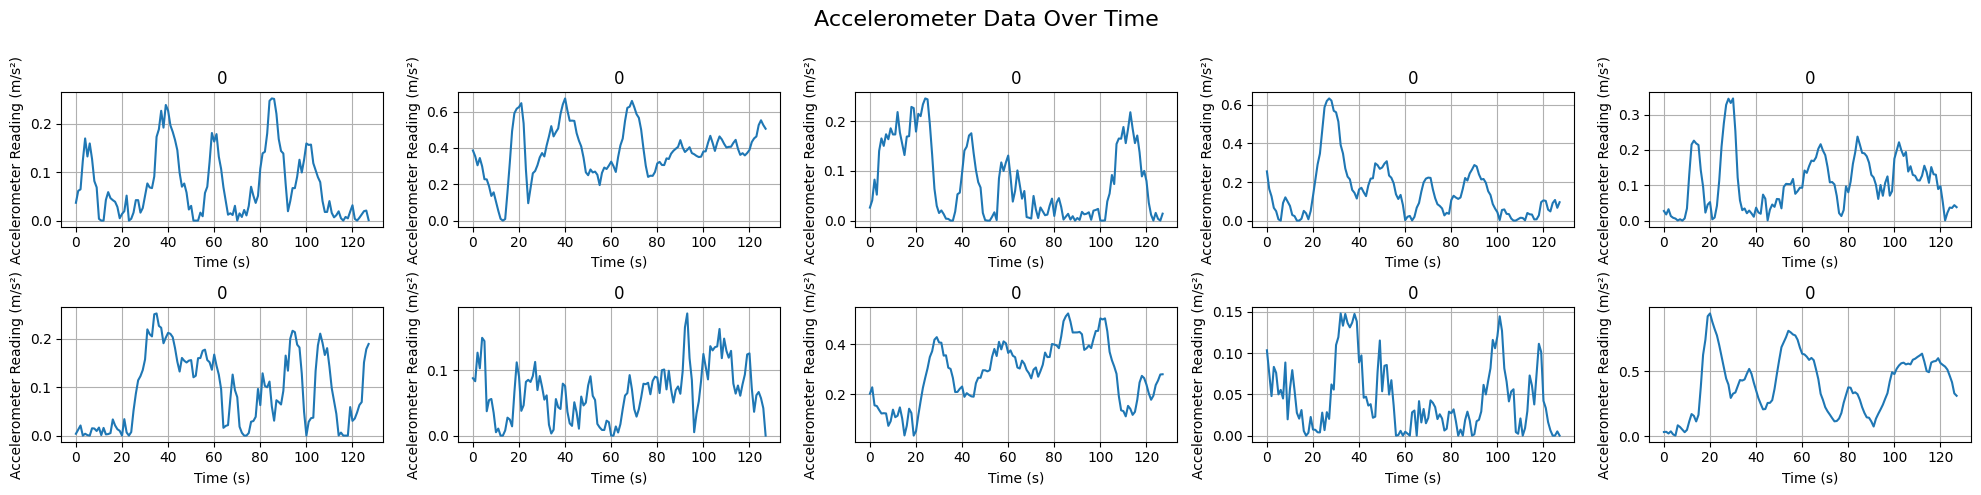

In [43]:
pot_signals(x, y)

In [45]:
n = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model
model = Unet1D_cls_free(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    num_classes = 42,
    cond_drop_prob = 0.5,
    channels = 1)

# Load the model checkpoint
checkpoint = torch.load('/content/checkpoint/DDPM1D_cls_free_Accelerometer/checkpoint.pt')
model_state_dict = checkpoint['model_state_dict']
optimizer_state_dict = checkpoint['optimizer']
model.load_state_dict(model_state_dict)
model = model.to(device)

# Define the diffusion model
diffusion = GaussianDiffusion1D_cls_free(
    model,
    seq_length = 128,
    timesteps = 1000).to(device)

# Modify class to 10
y = torch.Tensor([10] * n).long().to(device)

# Generate samples conditioned on class 10
x = diffusion.sample(classes = y, cond_scale = 3.)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

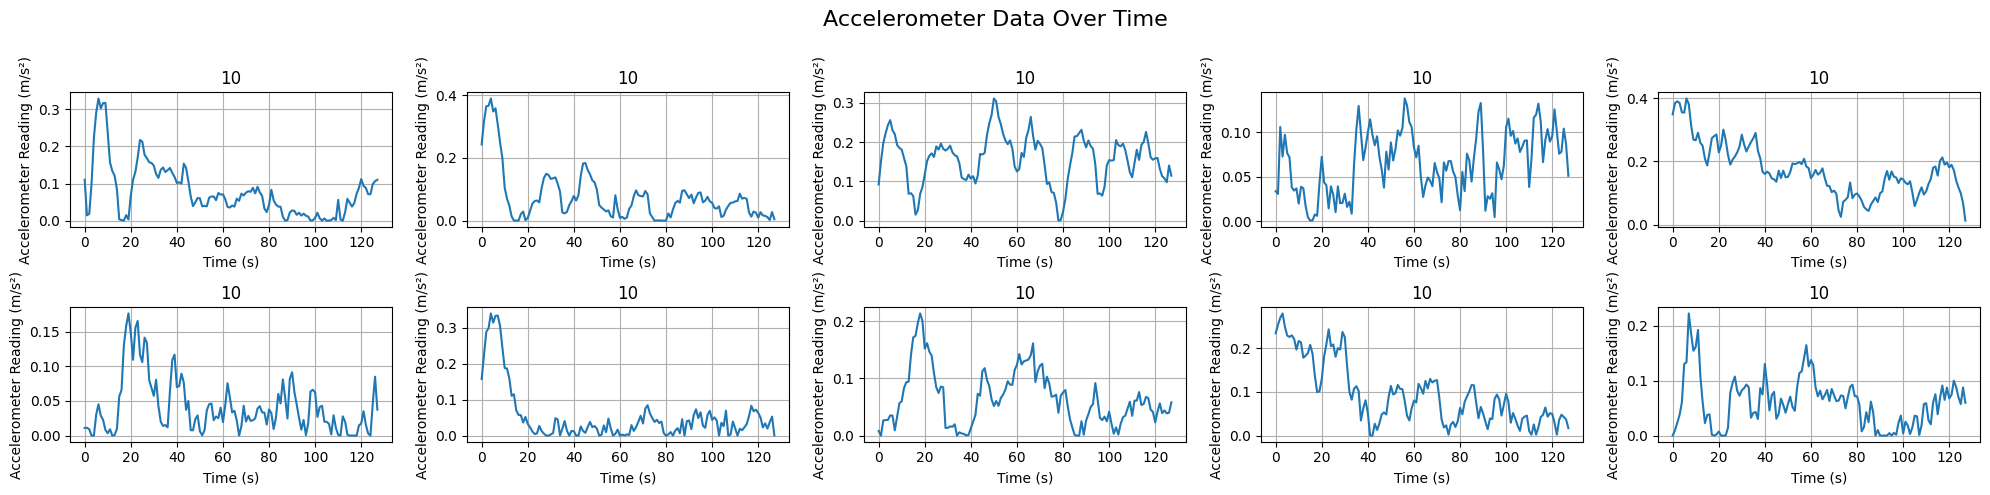

In [46]:
pot_signals(x, y)

In [47]:
n = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model
model = Unet1D_cls_free(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    num_classes = 42,
    cond_drop_prob = 0.5,
    channels = 1)

# Load the model checkpoint
checkpoint = torch.load('/content/checkpoint/DDPM1D_cls_free_Accelerometer/checkpoint.pt')
model_state_dict = checkpoint['model_state_dict']
optimizer_state_dict = checkpoint['optimizer']
model.load_state_dict(model_state_dict)
model = model.to(device)

# Define the diffusion model
diffusion = GaussianDiffusion1D_cls_free(
    model,
    seq_length = 128,
    timesteps = 1000).to(device)

# Modify class to 10
y = torch.Tensor([12] * n).long().to(device)

# Generate samples conditioned on class 10
x = diffusion.sample(classes = y, cond_scale = 3.)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

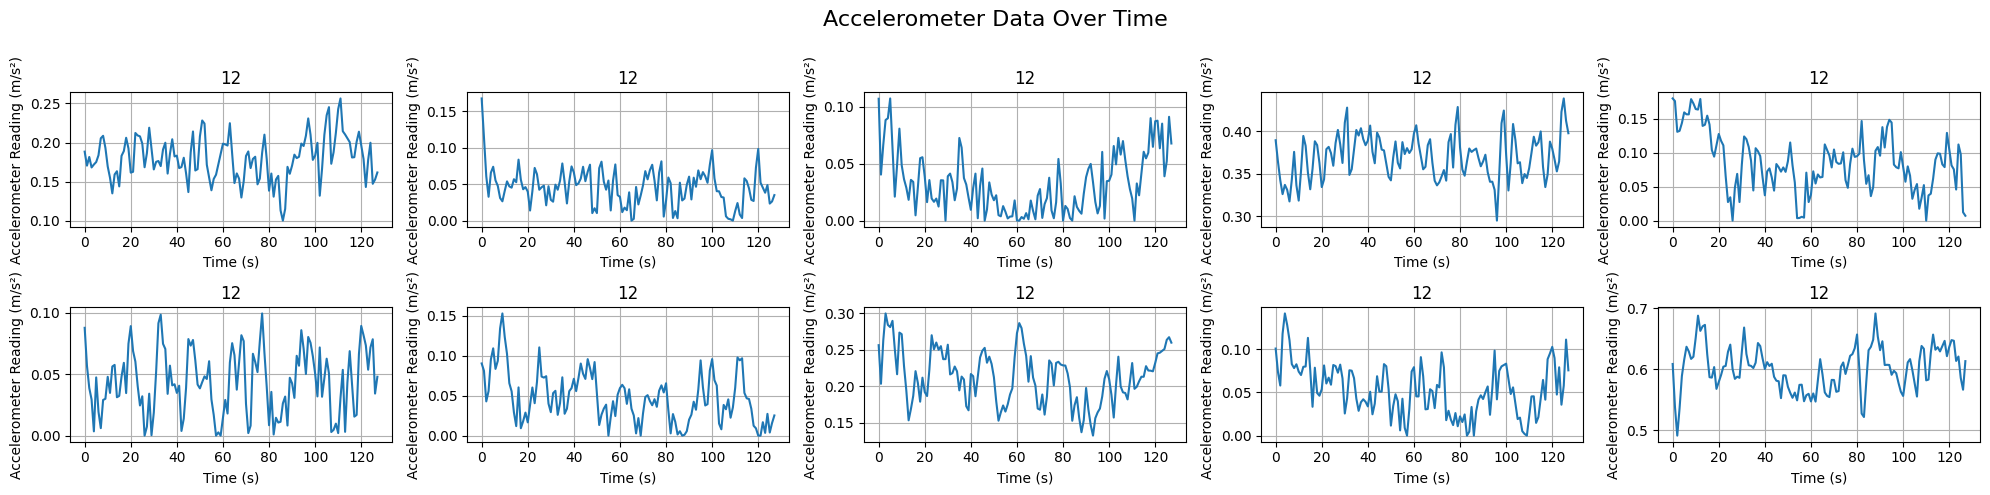

In [48]:
pot_signals(x, y)

In [49]:
n = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model
model = Unet1D_cls_free(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    num_classes = 42,
    cond_drop_prob = 0.5,
    channels = 1)

# Load the model checkpoint
checkpoint = torch.load('/content/checkpoint/DDPM1D_cls_free_Accelerometer/checkpoint.pt')
model_state_dict = checkpoint['model_state_dict']
optimizer_state_dict = checkpoint['optimizer']
model.load_state_dict(model_state_dict)
model = model.to(device)

# Define the diffusion model
diffusion = GaussianDiffusion1D_cls_free(
    model,
    seq_length = 128,
    timesteps = 1000).to(device)

# Modify class to 10
y = torch.Tensor([34] * n).long().to(device)

# Generate samples conditioned on class 10
x = diffusion.sample(classes = y, cond_scale = 3.)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

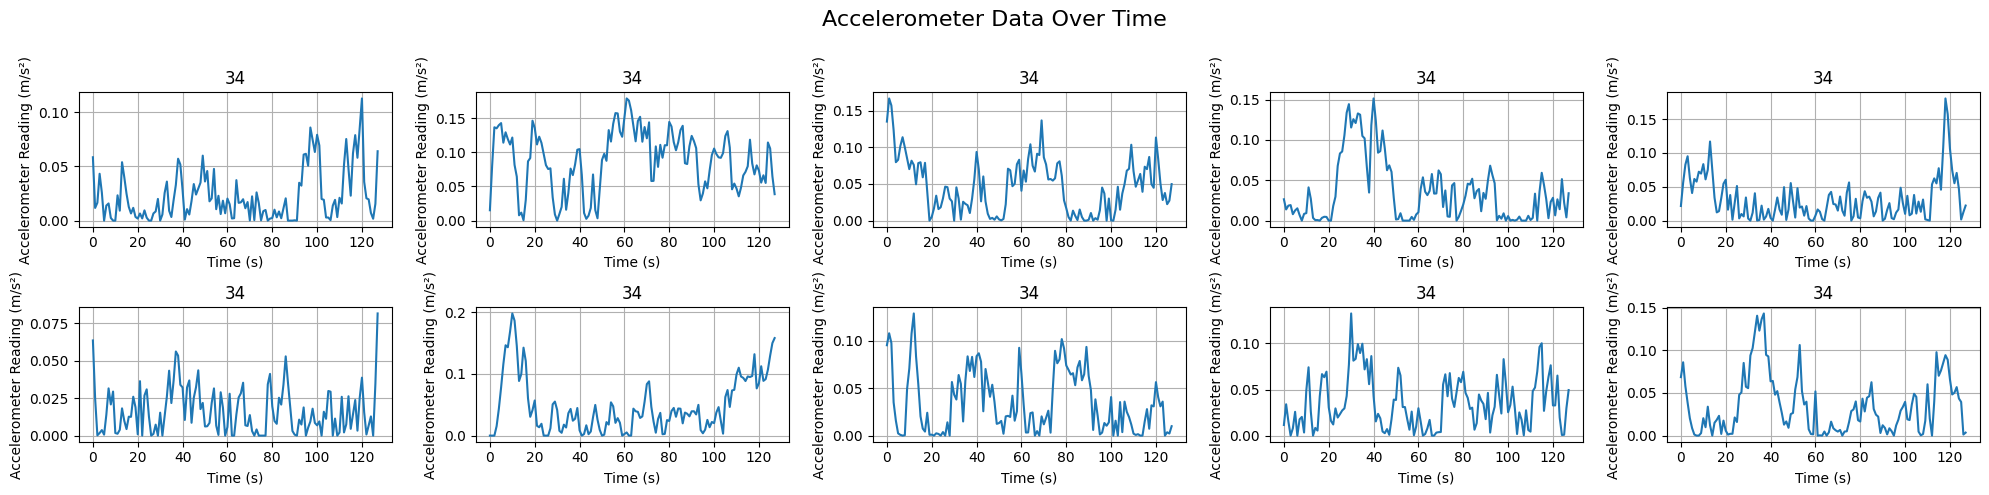

In [50]:
pot_signals(x, y)

generate plots from the ridi data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# Step 1: Load the transformed CSV file
acce_transformed_df = pd.read_csv('accelerometer_transformed (7).csv')

# Step 2: Filter for 'bag1' data
bag1_df = acce_transformed_df[acce_transformed_df['class_id'] == 'bag1']

# Step 3: Set up the subplots grid
num_plots = len(bag1_df)
plots_per_row = 5  # Set the number of plots per row
num_rows = math.ceil(num_plots / plots_per_row)

fig, axs = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 4, num_rows * 4), constrained_layout=True)

# Step 4: Iterate over each row and plot accelerometer values in subplots
for i, (index, row) in enumerate(bag1_df.iterrows()):
    # Extract first 10 accelerometer measurements
    acc_measurements = row.iloc[3:128].values  # Taking only first 10 x values

    # Calculate the row and column index for the current subplot
    row_idx = i // plots_per_row
    col_idx = i % plots_per_row

    # Plot the accelerometer measurements for this row in the respective subplot
    axs[row_idx, col_idx].plot(acc_measurements, label=f'Person {row["person"]}')
    axs[row_idx, col_idx].set_title(f'Person {row["person"]}')
    axs[row_idx, col_idx].set_xlabel('Time (s)')
    axs[row_idx, col_idx].set_ylabel('Accelerometer Reading (m/s²)')
    axs[row_idx, col_idx].grid(True)
    axs[row_idx, col_idx].legend()

# Hide any empty subplots
for j in range(i + 1, num_rows * plots_per_row):
    fig.delaxes(axs[j // plots_per_row, j % plots_per_row])

fig.suptitle('Real Accelerometer Data Over Time - class 0', fontsize=16)  # Title for the entire figure
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the suptitle
# Show the plots
plt.show()


In [64]:
import shutil

# Create a ZIP archive of the 'models' directory
shutil.make_archive('/content/models_archive', 'zip', '/content', 'models')
from google.colab import files

# Download the ZIP file
files.download('/content/models_archive.zip')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# Download the file
files.download('/content/checkpoint/DDPM1D_cls_free_Accelerometer/checkpoint.pt')


In [65]:
import shutil

# Create a ZIP archive of the 'results' directory
shutil.make_archive('/content/results_archive', 'zip', '/content', 'results')
from google.colab import files

# Download the ZIP file
files.download('/content/results_archive.zip')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
import shutil

# Create a ZIP archive of the 'runs' directory
shutil.make_archive('/content/runs_archive', 'zip', '/content', 'runs')
from google.colab import files

# Download the ZIP file
files.download('/content/runs_archive.zip')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
import shutil

# Create a ZIP archive of the 'checkpoint' directory
shutil.make_archive('/content/checkpoint_archive', 'zip', '/content', 'checkpoint')
from google.colab import files

# Download the ZIP file
files.download('/content/checkpoint_archive.zip')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
from google.colab import files
import shutil

# Create a ZIP archive of the 'biodiffusion' directory
shutil.make_archive('/content/biodiffusion_archive', 'zip', '/content', 'biodiffusion')

# Download the ZIP file
files.download('/content/biodiffusion_archive.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [79]:
import os
os.listdir('/content/biodiffusion/src/signal/modules')


['modules1D_cond.py', '__init__.py', 'modules1D_cls_free.py', '__pycache__']